In [1]:
import numpy as np
from matplotlib import pyplot as plt
import qcodes as qc
from qcodes.instrument_drivers.tektronix.Keithley_2600 import Keithley_2600 
from qcodes.instrument_drivers.stanford_research.SR865 import SR865
from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
import os
import sys
import time
import pandas
from pysweep import Measurement, sweep, measurement
from collections import OrderedDict
from scipy.optimize import leastsq

paths = [r"C:\Users\jowat\AppData\Local\Continuum\Anaconda3\envs\qcodes\Lib\site-packages\pysweep"
    
]

for p in paths:
    if p not in sys.path:
        sys.path.append(p)

In [2]:
%matplotlib notebook

In [3]:
keithley = Keithley_2600("keithley", "USB0::0x05E6::0x2614::4345885::INSTR",'a')
#lockin = SR865("lockin", "USB0::0xB506::0x2000::003230::INSTR")
#DMM = Keysight_34465A("DMM", "USB0::0x2A8D::0x0101::MY57504932::INSTR")
#Yokogawa = GS200("Yokogawa", "USB0::0xB21::0x39::91U100329::INSTR")

Connected to: Keithley Instruments Inc. 2614B (serial:4345885, firmware:3.2.2) in 0.28s


In [4]:
station = qc.Station(keithley)
Measurement.default_station = station
Measurement.set_station(station)
Measurement.use_storage('spyview')

In [16]:
#import pandas
#from pysweep import Measurement, sweep, measurement
#from collections import OrderedDict
#Measurement.default_station = station
#Measurement.set_station(station)


In [6]:
#Measurement.use_storage('spyview')

In [4]:
def setup(station, namespace):
    station.keithley.smua.output('on')
    time.sleep(1)
    return {}

def cleanup(station, namespace):
    return {}

def IVSweep(station, namespace):
    time.sleep(0.3)
    current = station.keithley.smua.curr()
    return OrderedDict({
        "Current": {"unit": "A", "value": current},
    })

def LockinSweep(station, namespace):
    time.sleep(0.3)
    current = station.lockin.X()
    return OrderedDict({
        "Current": {"unit": "A", "value": current},
    })
    

In [5]:
measure = Measurement(
    setup,
    cleanup,
    (
        sweep(station.keithley.smua.volt, np.linspace(2, 0, 51)),
        IVSweep,
    )
).run()

In [5]:
measure = Measurement(
    setup,
    cleanup,
    (
        sweep(station.lockin.frequency, np.linspace(10, 10000, 51)),
        IVSweep,
    )
).run()

In [61]:
#File info
DIR = r"C:\Users\jowat\data\2018-03-19"
fname = '470pF_200msdelay.txt'
fullpath = os.path.join(DIR, fname)
file = open(fullpath,'w')
file.write('Frequency (Hz) \t Vac (V) \t Ix (A) \t Iy (A) \t Z (Ohms) \n')


#Sweep parameters
f = np.linspace(100,500e3,600)
Vac = 0.001
delay1 = 5
delay2 = 0.2

#Run sweep
station.lockin.phase(-180) #To correct for fact that current pre-amp is an inverting amplifier
station.lockin.frequency(f[0])
station.lockin.amplitude(Vac)
time.sleep(delay1)

Z = np.empty(np.size(f),complex)
for i in range(np.size(f)):
    station.lockin.frequency(f[i])
    time.sleep(delay2)
    Ix = station.lockin.X()
    Iy = station.lockin.Y()
    Z[i] = Vac/(Ix + 1j*Iy)
    file.write(str(f[i]) + '\t' + str(Vac) + '\t' + str(Ix) + '\t' + str(Iy) + '\t' + str(Z[i]) +'\n')
    

plt.plot(f,Z.real, label='Real')
plt.plot(f,Z.imag, label='Imag')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Impedance (Ohms)')
plt.legend()
plt.show()
    




file.close()

## Fit data to model without parasitics
Assume V_AC and I_AC are known.  Extract C_D and R_D

In [6]:
def Z_no_P(f, p):
    omega = 2*np.pi*f    
    R_D,C_D = p
    Z = (1/R_D + (1j*omega*C_D))**-1
    return Z

def residuals_Z_no_P(p,f,Z):
    R,C = p
    omega = 2*np.pi*f
    sim=(1/R + (1j*omega*C))**-1
    a = Z-sim
    return a.real**2 + a.imag**2

c:\users\jowat\appdata\local\continuum\anaconda3\envs\qcodes\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


<IPython.core.display.Javascript object>


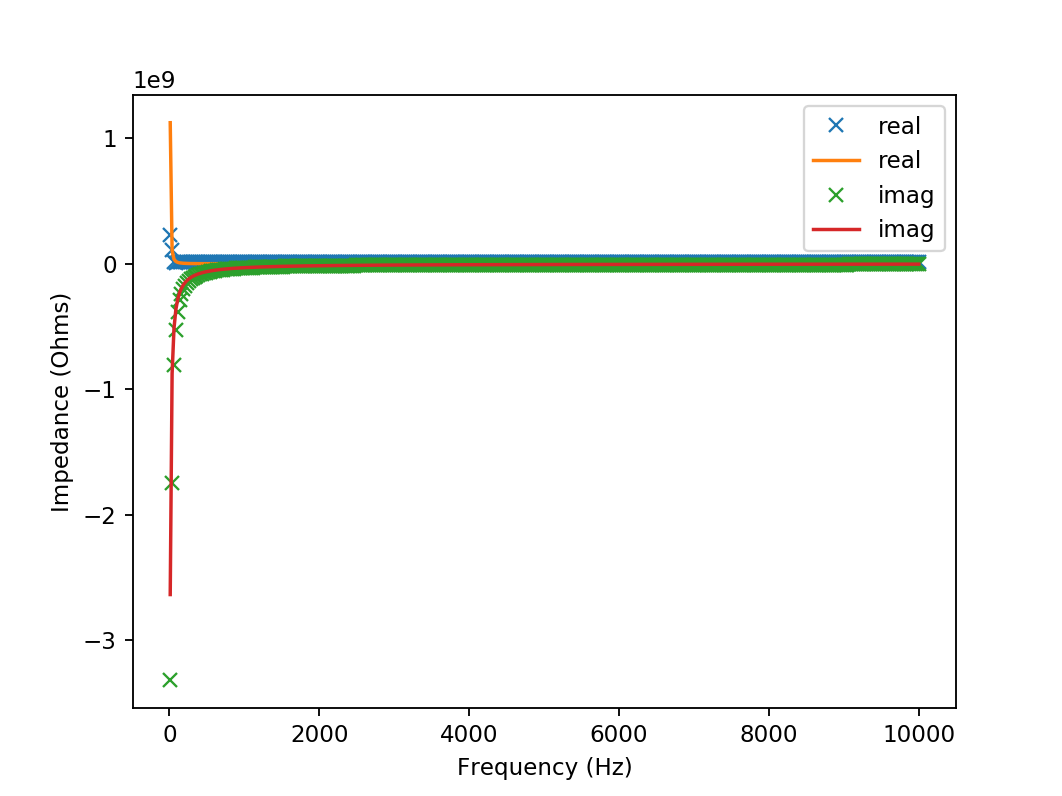

Fitted R: 7306.26655256 MOhms
Fitted C: 5.10895264273 pF


In [21]:
Z_data = Z
f_data = f

#Now do a fit to this data to try to extract the parameters R_fit and C_fit
x0=np.array([0.1e6, 400e-12]) #Initial guess at R and C, respectively
res = leastsq(residuals_Z_no_P,x0,args=(f_data,Z_data))

Z_fit = Z_no_P(f_data,np.array(res[0]))

plt.figure(3)
plt.plot(f_data,Z_data.real, 'x', label='real')
plt.plot(f_data,Z_fit.real, label='real')
plt.plot(f_data,Z_data.imag, 'x', label='imag')
plt.plot(f_data,Z_fit.imag, label='imag')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Impedance (Ohms)')
plt.legend()
#plt.show()

print('Fitted R: ' + str(res[0][0]/1e6) + ' MOhms')
print('Fitted C: ' + str(res[0][1]/1e-12) + ' pF')

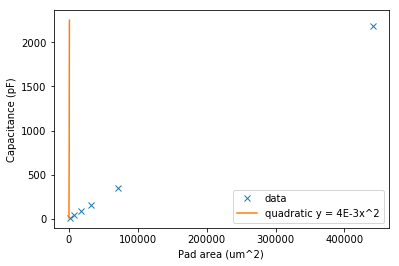

In [41]:
diameter = 1e-7*np.array([50, 100, 150, 200, 300, 750])
area = np.pi*(diameter/2)**2
capacitance = 1e-12*np.array([10, 39, 87, 154, 347, 2180])

x = np.linspace(50,750, 200)
y = 0.004*x**2
y2 = 
plt.plot(area*1e12, capacitance*1e12, 'x', label='data')
plt.plot(x,y, label='quadratic y = 4E-3x^2')
plt.xlabel('Pad area (um^2)')
plt.ylabel('Capacitance (pF)')
plt.legend()
plt.show()

## Analytic extraction of capacitance

<IPython.core.display.Javascript object>


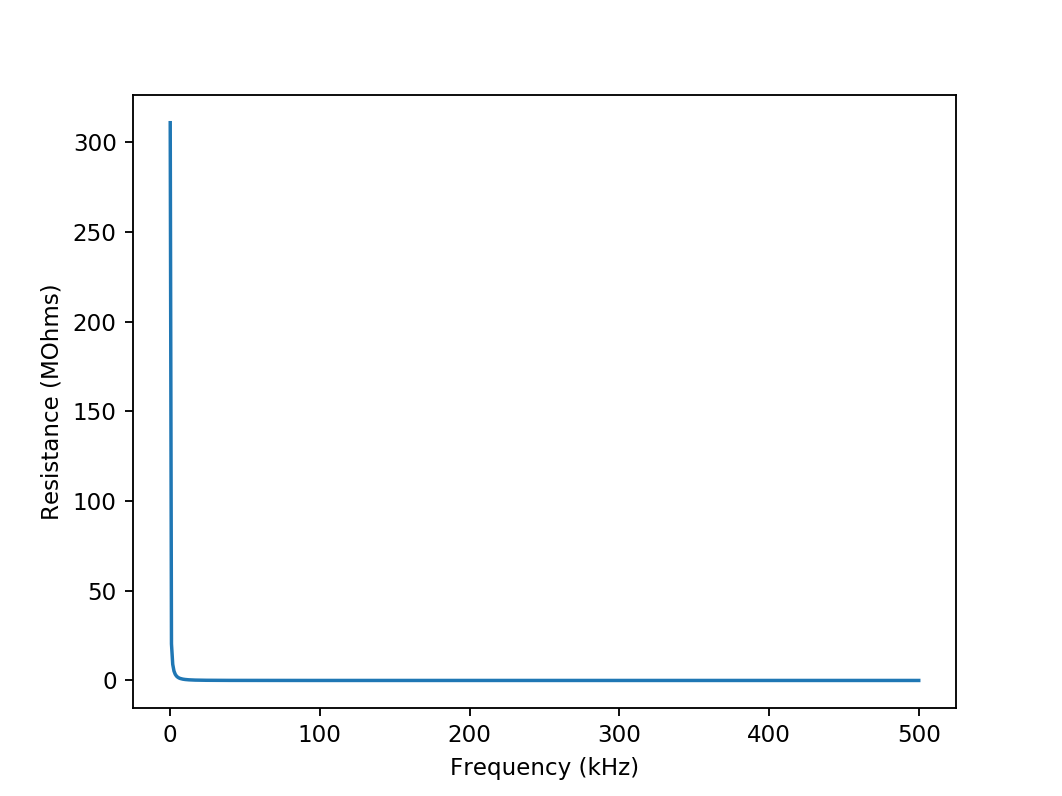

<IPython.core.display.Javascript object>


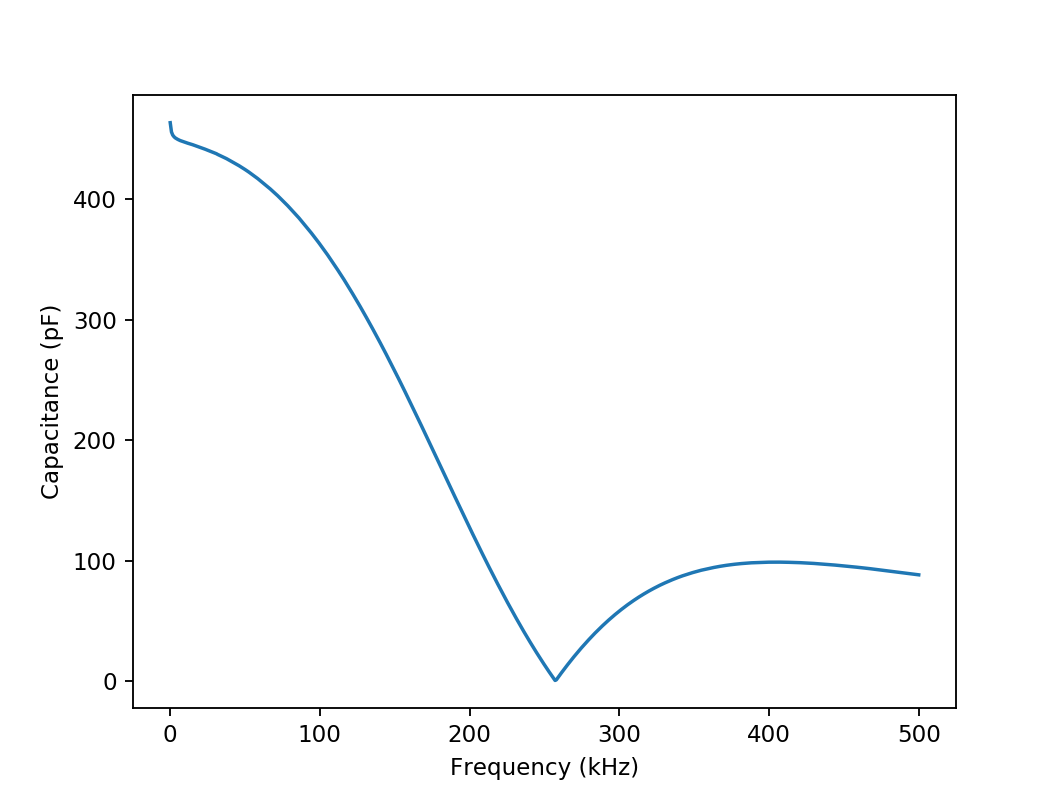

<IPython.core.display.Javascript object>


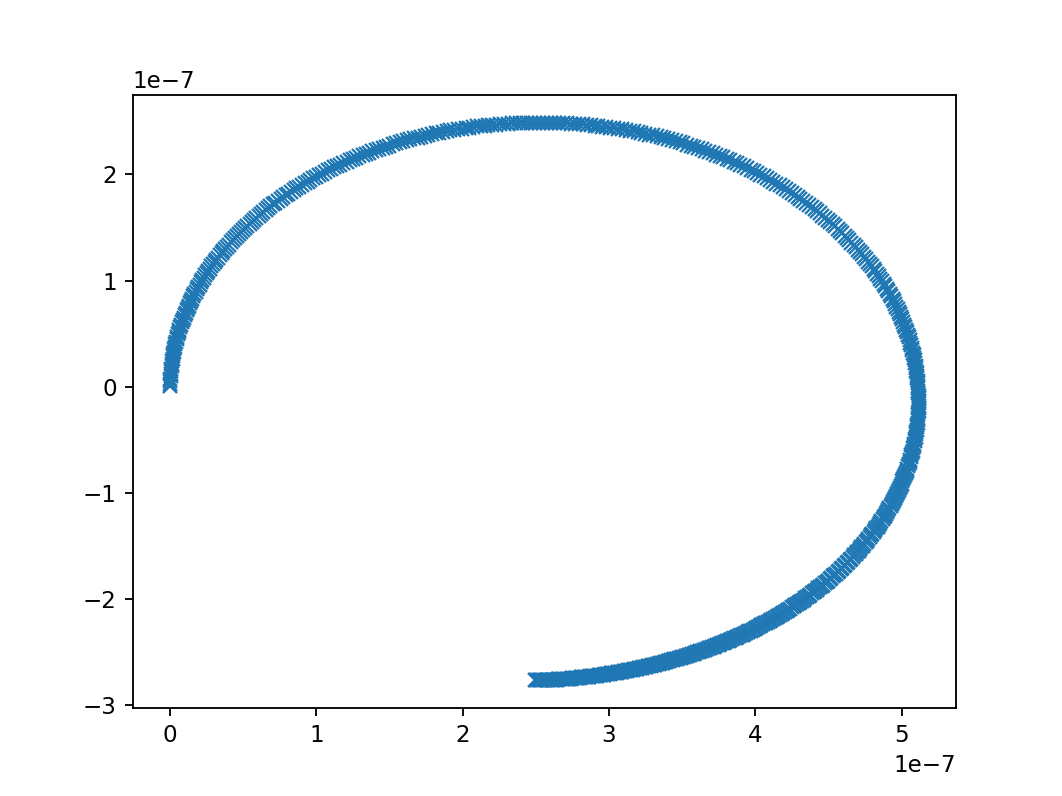

<IPython.core.display.Javascript object>


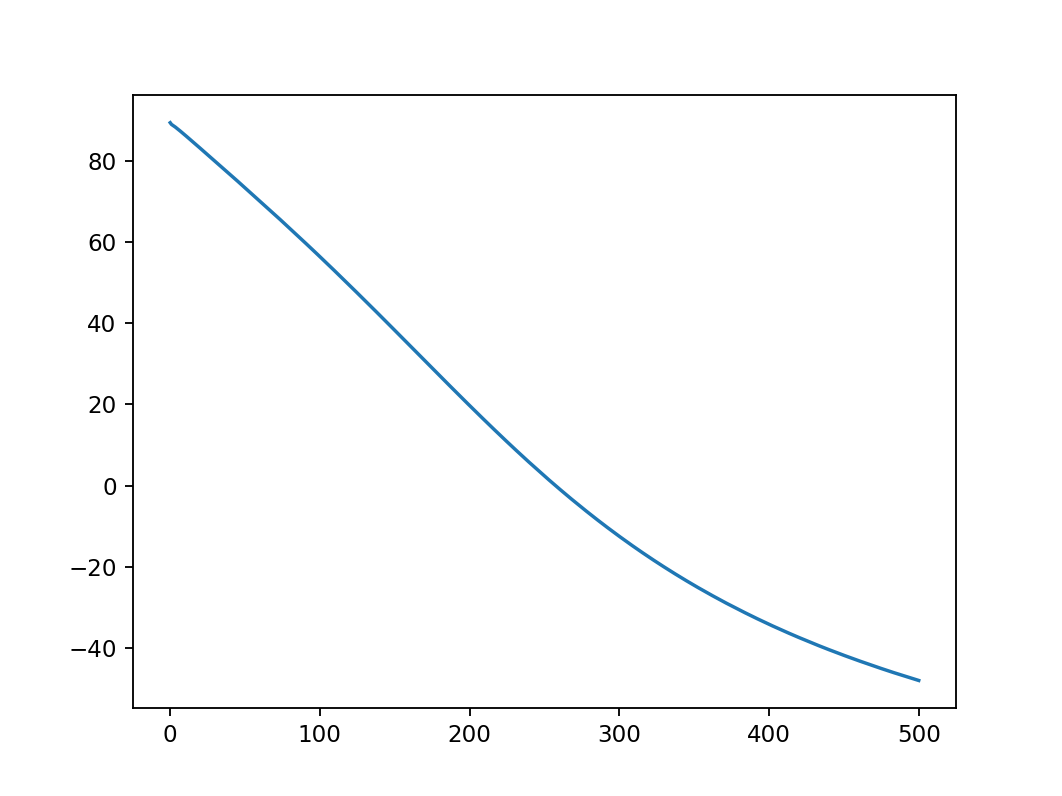

In [66]:
#File info
DIR = r"C:\Users\jowat\data\2018-03-19"
#fname = 'MOSCAP001_50um_1_light.txt'
fname = '470pF_200msdelay.txt'
fullpath = os.path.join(DIR, fname)
file = open(fullpath,'r')

d = np.genfromtxt(fullpath, delimiter='\t', skip_header=1)

f = d[:,0]
Vac = d[:,1]
Ix = d[:,2]
Iy = d[:,3]

I = Ix + 1j*Iy
Z = Vac/I

R = np.empty(len(f))
C = np.empty(len(f))
for i in range(len(f)):
    R[i] = abs(Z[i])**2/Z[i].real
    C[i] = np.sqrt(R[i]/Z[i].real - 1)/(2*np.pi*f[i]*R[i])

plt.figure(1)
plt.plot(f/1e3, R/1e6)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Resistance (MOhms)')
#plt.show()

plt.figure(2)
plt.plot(f/1e3, C/1e-12)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Capacitance (pF)')
#plt.show()

plt.figure(4)
plt.plot(Ix,Iy, 'x')
plt.figure(5)
plt.plot(f/1e3, 180/np.pi*np.arctan(Iy/Ix))


## I-V measurement with Yokogawa and DL1211 pre-amp

In [54]:
volt = np.linspace(0,0.001,100)
current = np.empty(len(volt))
gain = 1e-10
Navg = 5

'''
for i in range(len(volt)):
    Yokogawa.voltage(volt[i])
    time.sleep(0.1)
    current[i] = -DMM.volt()*gain
'''
Npoints = 100
delay = 0.2

t = np.linspace(0,Npoints*delay,Npoints)
temp = 0
for i in range(Npoints):
    for j in range(Navg):
        temp = temp - DMM.volt()*gain
        time.sleep(delay)
    current[i] = temp/Navg
    temp = 0
        

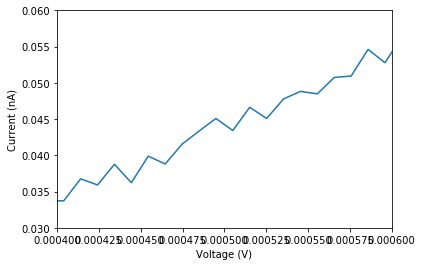

In [39]:
plt.plot(volt, current/1e-9)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (nA)')
plt.xlim([.0004,.0006])
plt.ylim([.03,.06])
plt.show()

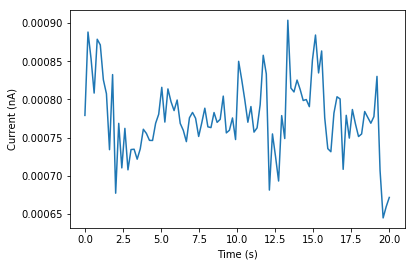

In [55]:
plt.plot(t, current/1e-9)
plt.xlabel('Time (s)')
plt.ylabel('Current (nA)')
plt.show()

In [ ]:
keithley.

## IV with Keithley 2614B

In [5]:
def keithleyramp(Vset):
    Vstart = keithlekeithley.voltVstep = 0.025
    voltage = np.linspace(Vstart,Vset,int(abs(Vstart-Vset)/Vstep))
    delay = 0.05
    for i in range(len(voltage)):
        keithley.volt(voltage[i])

In [36]:
#File info
#keithley = Keithley_2600("keithley", "USB0::0x05E6::0x2614::4345885::INSTR",'a')
DIR = r"C:\Users\jowat\data\2018-03-23"
#fname = 'MOSCAP001_50um_1_125mVps_15V_25mVstep_Navg1'


Device = 'MOSCAP001'
Column = 4
Diameter = 50 #[um]
Thickness = 36 #[nm]
Vstart = 0 #V
Vend = 20 #V
Vrate = 0.125 #V/s
Vstep = 0.025 #V
Navg = 1
keithley.limiti(500e-3)

fname = Device + '_' + str(Diameter) + 'um_' + str(Column) + '_' + str(Vrate*1000) + 'mVps_' + str(abs(Vend-Vstart)) + 'V_' + str(Vstep*1000) +'mVstep_Navg' + str(Navg)
fullpath = os.path.join(DIR, fname+'upsweep.txt')
file = open(fullpath,'w')
file.write('V (Volts) \t I (A) \n')


Npoints = int(abs(Vstart - Vend)/Vstep)
delay = Vstep/Vrate

A = np.pi*(Diameter*1e-4/2)**2 #[cm^-2]

volt = np.linspace(Vstart,Vend,Npoints)
Navg = 1


keithley.volt(volt[0])
keithley.output('on')

current = np.empty(len(volt))
J = current/A
E = volt/(Thickness*1e-7) #[V/cm]
#Npoints = 100

actual = keithley.volt()
eps = 10e-3
if abs(Vstart - actual) > eps:
    keithleyramp(Vstart)

#t = np.linspace(0,Npoints*delay,Npoints)
temp = 0
for i in range(len(volt)):
    if volt[i] > keithley.rangev():
        keithley.rangev(volt[i])
    keithley.volt(volt[i])
    for j in range(Navg):
        temp = temp + keithley.curr()
        time.sleep(delay)        
    current[i] = temp/Navg
    J[i] = current[i]/A
    file.write(str(volt[i]) + '\t' + str(current[i]) + '\t' + str(E[i]) + '\t' + str(J[i]) + '\n')
    temp = 0
    
file.close()

#keithley.close()
#keithley = Keithley_2600("keithley", "USB0::0x05E6::0x2614::4345885::INSTR",'a')

#File info
fullpath = os.path.join(DIR, fname+'downsweep.txt')
file = open(fullpath,'w')
file.write('V (Volts) \t I (A) \n')


voltdown = np.linspace(Vend, Vstart, Npoints)
currentdown = np.empty(len(volt))
Jdown = current/A
Edown = voltdown/(Thickness*1e-7) #[V/cm]
temp = 0
for i in range(len(volt)):
    #if volt[i] < keithley.rangev():
     #   keithley.rangev(volt[i])
    keithley.volt(voltdown[i])
    for j in range(Navg):
        temp = temp + keithley.curr()
        time.sleep(delay)        
    currentdown[i] = temp/Navg
    Jdown[i] = currentdown[i]/A
    #file.write(str(volt[i]) + '\t' + str(currentdown[i]) +'\n')
    file.write(str(voltdown[i]) + '\t' + str(currentdown[i]) + '\t' + str(Edown[i]) + '\t' + str(Jdown[i]) + '\n')
    temp = 0
    
file.close()
#keithley.close()

<IPython.core.display.Javascript object>


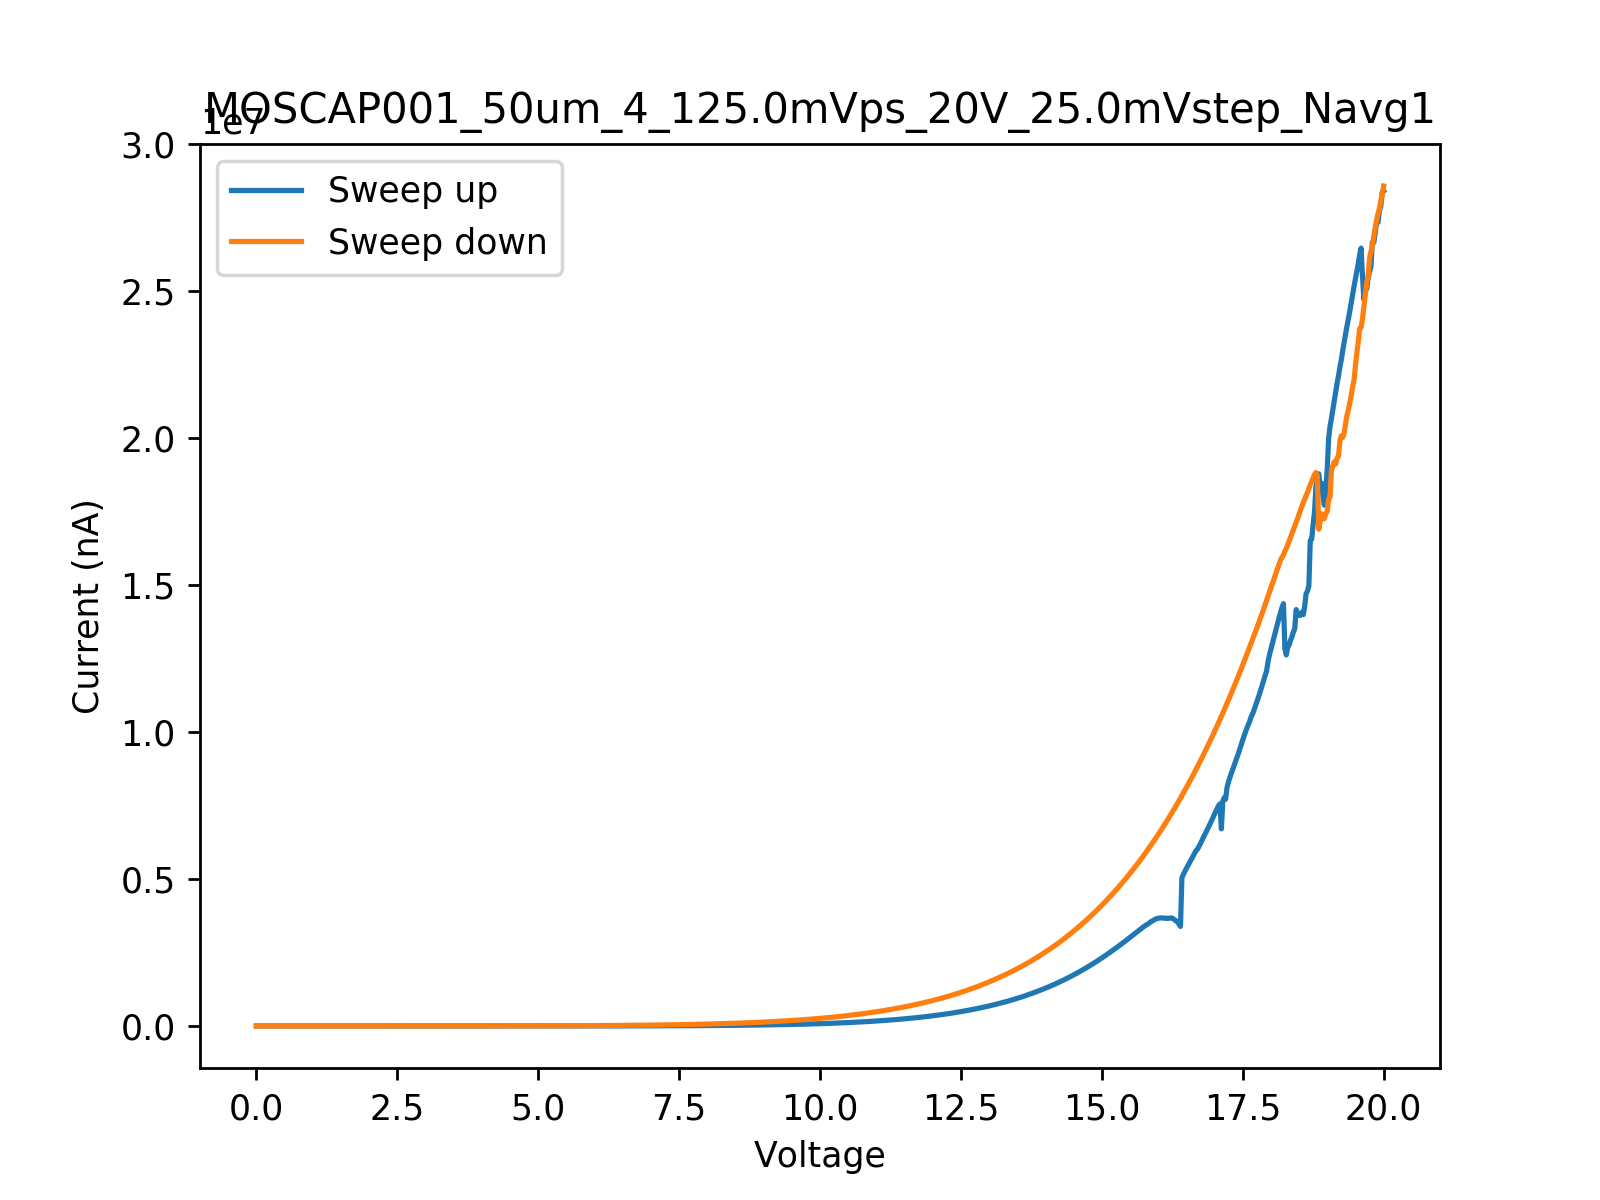

<IPython.core.display.Javascript object>


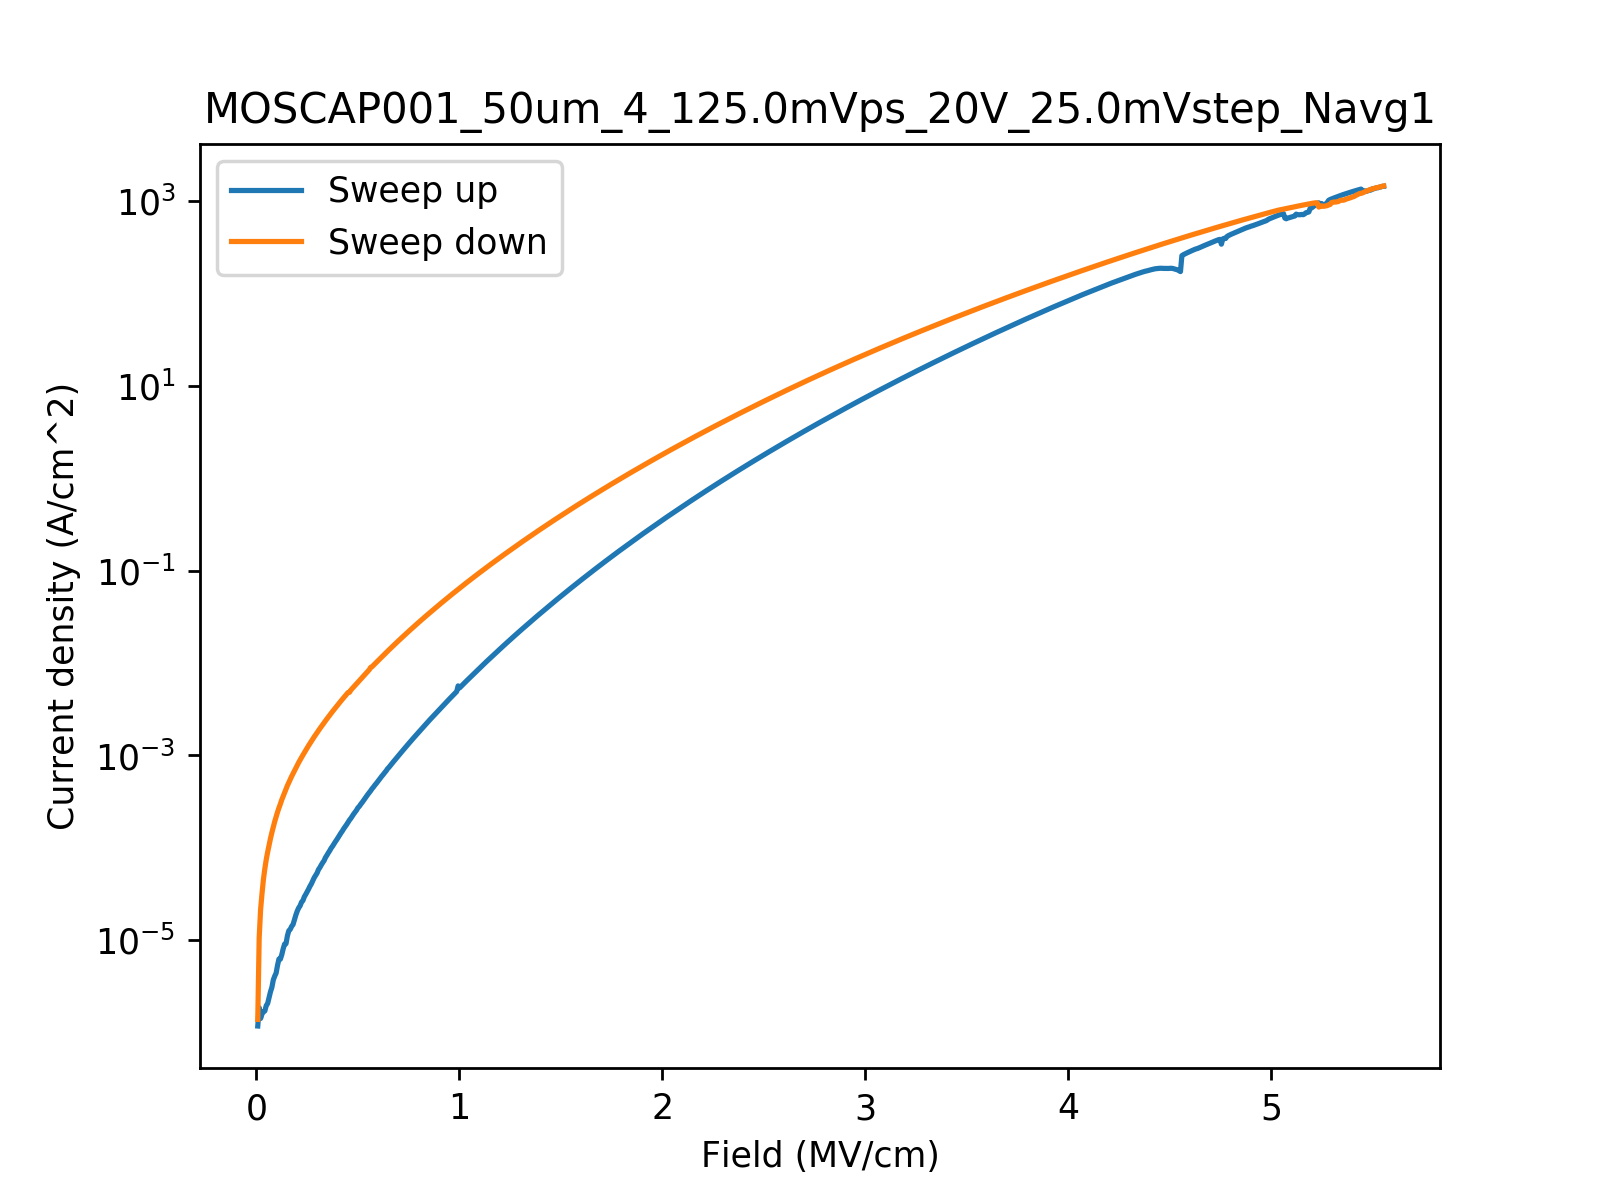

In [37]:
plt.figure(1)
plt.plot(volt, current/1e-9, label = 'Sweep up')
plt.plot(voltdown, currentdown/1e-9, label = 'Sweep down')
plt.xlabel('Voltage')
plt.ylabel('Current (nA)')
plt.title(fname)
#plt.ylim([-.1,.1])
plt.legend()
plt.show()

plt.figure(2)
plt.semilogy(E/1e6,J, label='Sweep up')
plt.semilogy(Edown/1e6, currentdown/A, label = 'Sweep down')
plt.xlabel('Field (MV/cm)')
plt.ylabel('Current density (A/cm^2)')
plt.title(fname)
plt.legend()
plt.show()

In [46]:
keithley.volt(0.5)

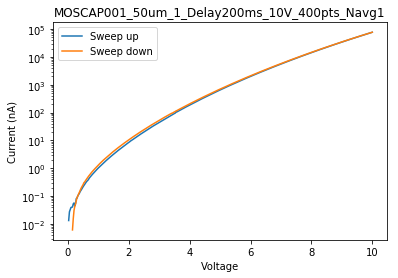

In [72]:
plt.semilogy(volt, current/1e-9, label = 'Sweep up')
plt.semilogy(voltdown, currentdown/1e-9, label = 'Sweep down')
plt.xlabel('Voltage')
plt.ylabel('Current (nA)')
plt.title(fname)
#plt.ylim([-.1,.1])
plt.legend()
plt.show()

In [21]:
volt = np.linspace(0,5,200)
current = np.empty(len(volt))


for i in range(len(volt)):
    keithley.volt(volt[i])
    time.sleep(0.2)
    current[i] = keithley.curr()

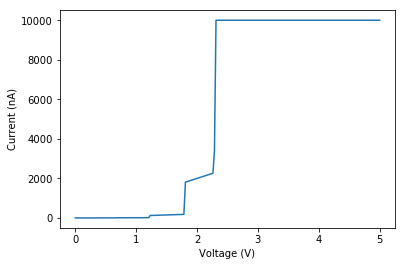

In [22]:
plt.plot(volt, current/1e-9)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (nA)')
plt.show()

In [40]:
1/(2*np.pi*station.lockin.frequency()*station.lockin.amplitude()/station.lockin.R())

4.5620410074314e-10

In [53]:
station.lockin.frequency(500000)

In [53]:
L = 64e-12*50**2

In [43]:
1/(2*np.pi*470e-12*500e3)

677.2550769867886

# Analyze input impedance of lockin
Want to correct for input/shunt impedance so we can measure capacitances beyond ~20kHz

In [ ]:
def residuals_Z_no_P(p,f,Z):
    R,C = p
    omega = 2*np.pi*f
    sim=(1/R + (1j*omega*C))**-1
    a = Z-sim
    return a.real**2 + a.imag**2